In [1]:
from picamera2 import Picamera2
import libcamera
import time
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
cam = Picamera2()

[0:21:32.587562877] [4723]  INFO Camera camera_manager.cpp:327 libcamera v0.4.0+53-29156679
[0:21:32.595015961] [4739]  INFO RPI pisp.cpp:720 libpisp version v1.1.0 e7974a156008 27-01-2025 (21:50:51)
[0:21:32.604718236] [4739]  INFO RPI pisp.cpp:1179 Registered camera /base/axi/pcie@120000/rp1/i2c@88000/imx219@10 to CFE device /dev/media2 and ISP device /dev/media0 using PiSP variant BCM2712_D0


In [41]:
config = cam.create_video_configuration(
	buffer_count=1,
	queue=False,
)

cam.stop()
cam.configure(config)

[0:35:10.822703607] [4743]  INFO Camera camera.cpp:1202 configuring streams: (0) 1280x720-XBGR8888 (1) 1920x1080-BGGR_PISP_COMP1
[0:35:10.827446487] [4739]  INFO RPI pisp.cpp:1484 Sensor: /base/axi/pcie@120000/rp1/i2c@88000/imx219@10 - Selected sensor format: 1920x1080-SBGGR10_1X10 - Selected CFE format: 1920x1080-PC1B


In [42]:
cam.start()

In [48]:
%timeit cam.capture_array()

33.4 ms ± 40.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


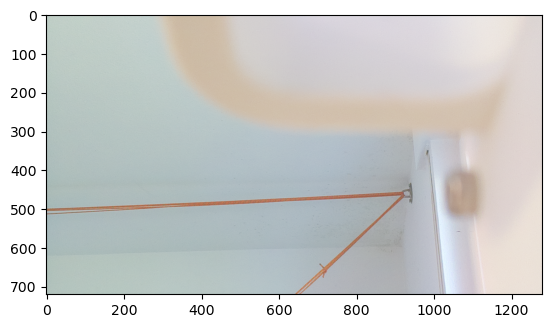

In [43]:
plt.imshow(cam.capture_array()[...,:3])

# Measure latency

In [23]:
import serial
ser = serial.Serial('/dev/ttyACM0')

getAngle = lambda: float(ser.readline()) # 200 us
def setAngle(a):
	if(a>=0 and a<2*math.pi):
		ser.write(b'T'+bytes(f"{a:f}", "ascii")+b'\n')
		return True
	return False
rad_frame = 0.541 * np.array([16/9, 1])

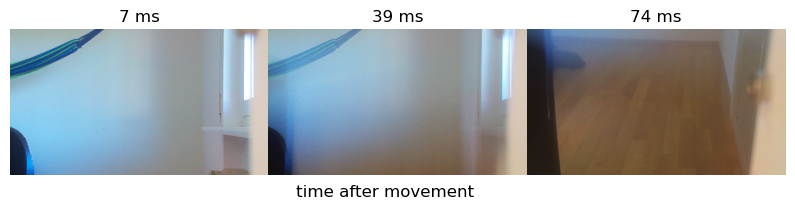

In [44]:
setAngle(math.pi)
time.sleep(0.3)

def get_image():
    i = cam.capture_array()[:,:,:3]
    t = time.time()
    return (t, i)

setAngle(math.pi+0.5)
start = time.time()
data = [get_image() for i in range(3)]

times = [t[0]-start for t in data]
times
images = [t[1] for t in data][:4]


time.sleep(0.5)
setAngle(math.pi)

f, ax = plt.subplots(1, len(images), figsize=(10,2))
for a, t, i in zip(ax.flatten(), times, images):
    a.imshow(i)
    a.axis("off")
    a.set_title(f"{round(t*1000)} ms")
f.supxlabel("time after movement")
plt.subplots_adjust(wspace=0)
plt.show()

# Find the scale

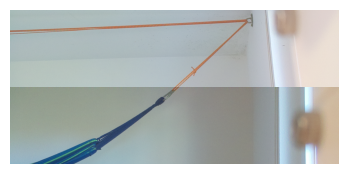

In [40]:
a = math.pi-.5
b = 0.415

def get_image():
    i = cam.capture_array()[:,:,:3]
    return i

setAngle(a)
time.sleep(0.5)
upper = get_image()[-300:]

setAngle(a+b)
time.sleep(0.5)
lower = get_image()[:300]

setAngle(a)

f, ax = plt.subplots(2, 1, figsize=(10,2))
for a, i in zip(ax, [upper, lower]):
    a.imshow(i)
    a.axis("off")
plt.subplots_adjust(hspace=0)
plt.show()